In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import make_spd_matrix

In [3]:
import sys
sys.path.insert(1, '/Users/ersi/Documents/ott/')

In [4]:
from ott.tools.gaussian_mixture import gaussian_mixture

In [5]:
from ott.core import bar_problems
from ott.core import continuous_barycenter, sinkhorn
from ott.geometry import costs, pointcloud
from gauss_mixture_utils import gauss_mixture_mean_and_cov_to_pointcloud, gauss_mixture_pointcloud_to_mean_and_cov
d = 2  # dimensionality

In [6]:
key = jax.random.PRNGKey(0)

In [7]:
sample_size = 2000

In [8]:
num_of_components = 2

In [9]:
keys = jax.random.split(key, num=2*num_of_components+3)

In [10]:
d = 2 # dimension

In [11]:
seeds = [2, 5, 12]

In [12]:
means1 = jnp.asarray([jax.random.randint(key=keys[i], shape=(d,), minval=-10, maxval=10) for i in range(num_of_components)])

In [13]:
scale = 1 #1e-6

In [14]:
covs1 = scale * jnp.asarray([make_spd_matrix(n_dim=d, random_state=seeds[i])
                    for i in range(num_of_components)])

In [15]:
# covs1 = scale * jnp.asarray([jnp.eye(d)
#                     for i in range(num_of_components)])

In [16]:
weights1 = jnp.asarray([0.5, 0.5])

In [17]:
gmm_generator1 = gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(mean=means1,
                                                                                 cov=covs1,
                                                                                 component_weights=weights1)

In [18]:
samples1 = gmm_generator1.sample(key=keys[-1], size=sample_size)

In [19]:
means2 = jnp.asarray([jax.random.randint(key=keys[i + num_of_components], shape=(d,), minval=-10, maxval=10) for i in range(num_of_components)])

In [20]:
covs2 = scale * jnp.asarray([make_spd_matrix(n_dim=d, random_state=seeds[i])
                    for i in range(num_of_components)])

In [21]:
# covs2 = scale * jnp.asarray([jnp.eye(d)
#                     for i in range(num_of_components)])

In [22]:
weights2 = jnp.asarray([0.5, 0.5])

In [23]:
gmm_generator2 = gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(mean=means2,
                                                                                 cov=covs2,
                                                                                 component_weights=weights2)

In [24]:
samples2 = gmm_generator2.sample(key=keys[-2], size=sample_size)

In [25]:
pointcloud1 = gauss_mixture_mean_and_cov_to_pointcloud(means=means1, covariances=covs1, dimension=d, num_components=num_of_components)

In [26]:
pointcloud2 = gauss_mixture_mean_and_cov_to_pointcloud(means=means2, covariances=covs2, dimension=d, num_components=num_of_components)

In [27]:
y = jnp.concatenate((pointcloud1, pointcloud2))

In [28]:
b = jnp.concatenate((weights1, weights2))

In [29]:
b

DeviceArray([0.5, 0.5, 0.5, 0.5], dtype=float32)

In [30]:
epsilon = 1 #0.001

In [31]:
weights = jnp.asarray([1,0])

In [32]:
weights.shape[0]

2

In [33]:
bar_p = bar_problems.BarycenterProblem(
      y, b, weights, num_per_segment=jnp.asarray([num_of_components, num_of_components]), num_segments=2, max_measure_size=num_of_components,
      cost_fn = costs.Bures(dimension=d),
      epsilon=epsilon, debiased=False)

In [34]:
solver = continuous_barycenter.WassersteinBarycenter(lse_mode=True)

In [35]:
bar_size = 2
weights_bary = jnp.ones(bar_size) / bar_size
# weights_bary = jnp.asarray([1, 0])
out = solver(bar_p, bar_size=bar_size)
barycenter = out.x

In [36]:
means_bary, covs_bary = gauss_mixture_pointcloud_to_mean_and_cov(pointcloud=barycenter, dimension=d, num_components=bar_size)

In [37]:
gmm_generator_bary = gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(mean=means_bary,
                                                                                      cov=covs_bary,
                                                                                      component_weights=weights_bary)

In [38]:
samples_bary = gmm_generator_bary.sample(key=keys[-3], size=sample_size)

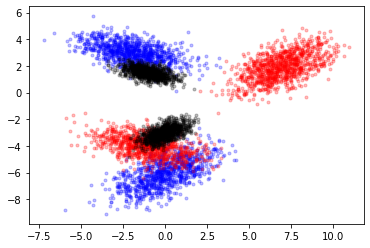

In [39]:
# Plot samples
plt.scatter(samples1[:, 0], samples1[:, 1], marker='.', alpha=0.25, c='b')
plt.scatter(samples2[:, 0], samples2[:, 1], marker='.', alpha=0.25, c='r')
plt.scatter(samples_bary[:, 0], samples_bary[:, 1], marker='.', alpha=0.25, c='k')
plt.show()

In [40]:
means_bary

DeviceArray([[-1.0000000e+00,  1.5000000e+00],
             [-8.3116418e-17, -3.0000014e+00]], dtype=float32)

In [41]:
means1

DeviceArray([[-2,  3],
             [ 0, -6]], dtype=int32)

In [42]:
means2

DeviceArray([[-1, -4],
             [ 7,  2]], dtype=int32)

In [43]:
geom1 = pointcloud.PointCloud(barycenter, pointcloud1, epsilon=epsilon)
out1 = sinkhorn.sinkhorn(geom1, weights_bary, weights1)
P1 = geom1.transport_from_potentials(out1.f, out1.g)

In [44]:
P1.shape

(2, 2)

In [45]:
geom2 = pointcloud.PointCloud(barycenter, pointcloud2, epsilon=epsilon)
out2 = sinkhorn.sinkhorn(geom2, weights_bary, weights2)
P2 = geom2.transport_from_potentials(out2.f, out2.g)

In [46]:
means1[0]

DeviceArray([-2,  3], dtype=int32)

In [47]:
B11_mean = P1[0,0] * means1[0] + P1[0,1] * means1[1]

In [48]:
B21_mean = P1[1,0] * means2[0] + P1[1,1] * means2[1]

In [49]:
B12_mean = P2[0,0] * means1[0] + P2[0,1] * means1[1]

In [50]:
B22_mean = P2[1,0] * means2[0] + P2[1,1] * means2[1]

In [51]:
mean1 = weights[0] * B11_mean + weights[1] * B21_mean

In [52]:
mean2 = weights[0] * B12_mean + weights[1] * B22_mean

In [53]:
mean1

DeviceArray([-1. ,  1.5], dtype=float32)

In [54]:
mean2

DeviceArray([-1.1930451e-12, -3.0000043e+00], dtype=float32)

In [55]:
means_bary

DeviceArray([[-1.0000000e+00,  1.5000000e+00],
             [-8.3116418e-17, -3.0000014e+00]], dtype=float32)

In [56]:
covs_bary

DeviceArray([[[ 0.5637669 , -0.1194063 ],
              [-0.11940618,  0.1239088 ]],

             [[ 0.51441246,  0.2159538 ],
              [ 0.21595384,  0.26062712]]], dtype=float32)

In [57]:
covs1

DeviceArray([[[ 2.2550676 , -0.47762507],
              [-0.47762507,  0.495635  ]],

             [[ 2.057648  ,  0.8638142 ],
              [ 0.8638142 ,  1.042507  ]]], dtype=float32)

In [58]:
covs2

DeviceArray([[[ 2.2550676 , -0.47762507],
              [-0.47762507,  0.495635  ]],

             [[ 2.057648  ,  0.8638142 ],
              [ 0.8638142 ,  1.042507  ]]], dtype=float32)